In [1]:
import os
import sys
sys.path.append('../..')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandarallel import pandarallel
from helpers.utils import (
    RP_VALUES,
    get_ps1_or_host,
    clean_dataset,
    tranform_legacy,
    create_rp_stats_inframe_df,
    transform_response,
    create_resp_rp_stats_third_party_df,
    doc_wide
)

In [2]:
intersection_file = '../../helpers/intersection'

with open(intersection_file, "r") as file:
    intersection = file.read().splitlines()

In [3]:
pandarallel.initialize()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Meta-tag

In [4]:
# meta_path = '../../output/data_raw/2025-02-08_noAct_meta.parquet'
meta_path = '../../output/data_raw/2024-01-24_SF_meta.parquet'

meta = pd.read_parquet(meta_path)

In [5]:
import re
match = re.search(r'(\d{4}-\d{2}-\d{2})_([^_]+)', meta_path)
if match:
    extract_date, extract_type = match.groups()
    print("Date:", extract_date)
    print("Type:", extract_type)

Date: 2024-01-24
Type: SF


In [6]:
meta = clean_dataset(meta, intersection)

In [7]:
meta['final_host'] = meta.final_url.parallel_apply(get_ps1_or_host)
meta['frame_host'] = meta.frameUrl.parallel_apply(get_ps1_or_host)

In [8]:
meta.groupby('referrer_policy').final_host.nunique()

referrer_policy
always                              108
default                               1
never                                15
no-referrer                         718
no-referrer-when-downgrade          312
none                                  1
origin                              682
origin-when-cross-origin             39
origin-when-crossorigin            1069
same-origin                          12
strict-origin                         4
strict-origin-when-cross-origin     113
unsafe-URL                            2
unsafe-url                          158
Name: final_host, dtype: int64

In [9]:
meta['ref_pol_fix'] = meta.parallel_apply(tranform_legacy, axis=1)

In [10]:
#Table 6
meta.groupby('ref_pol_fix').final_host.nunique()

ref_pol_fix
ignored                               1
no-referrer                         733
no-referrer-when-downgrade          312
origin                              682
origin-when-cross-origin           1108
same-origin                          12
strict-origin                         4
strict-origin-when-cross-origin     114
unsafe-url                          266
Name: final_host, dtype: int64

In [11]:
# Table 20
meta[~meta.referrer_policy.isin(RP_VALUES)]

,init_url,final_url,failed_visit,referrer_policy,frameUrl,inFrame,pageURL,final_host,frame_host,ref_pol_fix
0,https://souffle.life/manga/ohayou-oyasumi-mata...,https://souffle.life/manga/ohayou-oyasumi-mata...,False,origin-when-crossorigin,https://www.facebook.com/v3.2/plugins/share_bu...,True,https://souffle.life/manga/ohayou-oyasumi-mata...,souffle.life,facebook.com,origin-when-cross-origin
1,https://souffle.life/manga/ohayou-oyasumi-mata...,https://souffle.life/manga/ohayou-oyasumi-mata...,False,origin-when-crossorigin,https://www.facebook.com/v3.2/plugins/share_bu...,True,https://souffle.life/manga/ohayou-oyasumi-mata...,souffle.life,facebook.com,origin-when-cross-origin
6,https://ternanacalcio.com/domattina-rifinitura...,https://ternanacalcio.com/domattina-rifinitura...,False,origin-when-crossorigin,https://www.facebook.com/plugins/like.php?href...,True,https://ternanacalcio.com/domattina-rifinitura...,ternanacalcio.com,facebook.com,origin-when-cross-origin
10,https://www.slevici.cz/detail-slevy/netradicni...,https://www.slevici.cz/detail-slevy/netradicni...,False,origin-when-crossorigin,https://www.facebook.com/plugins/like.php?href...,True,https://www.slevici.cz/detail-slevy/netradicni...,slevici.cz,facebook.com,origin-when-cross-origin
11,https://www.slevici.cz/detail-slevy/netradicni...,https://www.slevici.cz/detail-slevy/netradicni...,False,origin-when-crossorigin,https://www.facebook.com/plugins/like.php?href...,True,https://www.slevici.cz/detail-slevy/netradicni...,slevici.cz,facebook.com,origin-when-cross-origin
...,...,...,...,...,...,...,...,...,...,...
16206,https://aoten.jp/register,https://aoten.jp/register/,False,origin-when-crossorigin,https://www.facebook.com/v2.5/plugins/like.php...,True,https://aoten.jp/register/,aoten.jp,facebook.com,origin-when-cross-origin
16208,https://kumomanga.net/manga,https://kumomanga.net/manga/,False,origin-when-crossorigin,https://www.facebook.com/v12.0/plugins/page.ph...,True,https://kumomanga.net/manga/,kumomanga.net,facebook.com,origin-when-cross-origin
16215,https://www.surveyclub.com/privacy-policy,https://www.surveyclub.com/privacy-policy,False,origin-when-crossorigin,https://www.facebook.com/v2.0/plugins/like.php...,True,https://www.surveyclub.com/privacy-policy,surveyclub.com,facebook.com,origin-when-cross-origin
16216,http://www.romannumerals.co/date-converter,http://www.romannumerals.co/date-converter,False,origin-when-crossorigin,https://www.facebook.com/v2.3/plugins/like.php...,True,http://www.romannumerals.co/date-converter,romannumerals.co,facebook.com,origin-when-cross-origin


In [12]:
# Websites with meta-tag referrer policy
meta[meta.ref_pol_fix.isin(RP_VALUES)].final_host.nunique()

3040

In [13]:
drop_meta = meta.drop_duplicates(subset=['final_host', 'inFrame', 'ref_pol_fix'])

In [14]:
inframe_meta_h = create_rp_stats_inframe_df(drop_meta, RP_VALUES)

/data/referrer-policy/artifact/RP-Analyzer/03_analyzer/0301_implement/../../helpers/utils.py:705: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'percentage': normalized_counts[i]


In [15]:
os.makedirs("../../output/chart", exist_ok=True)

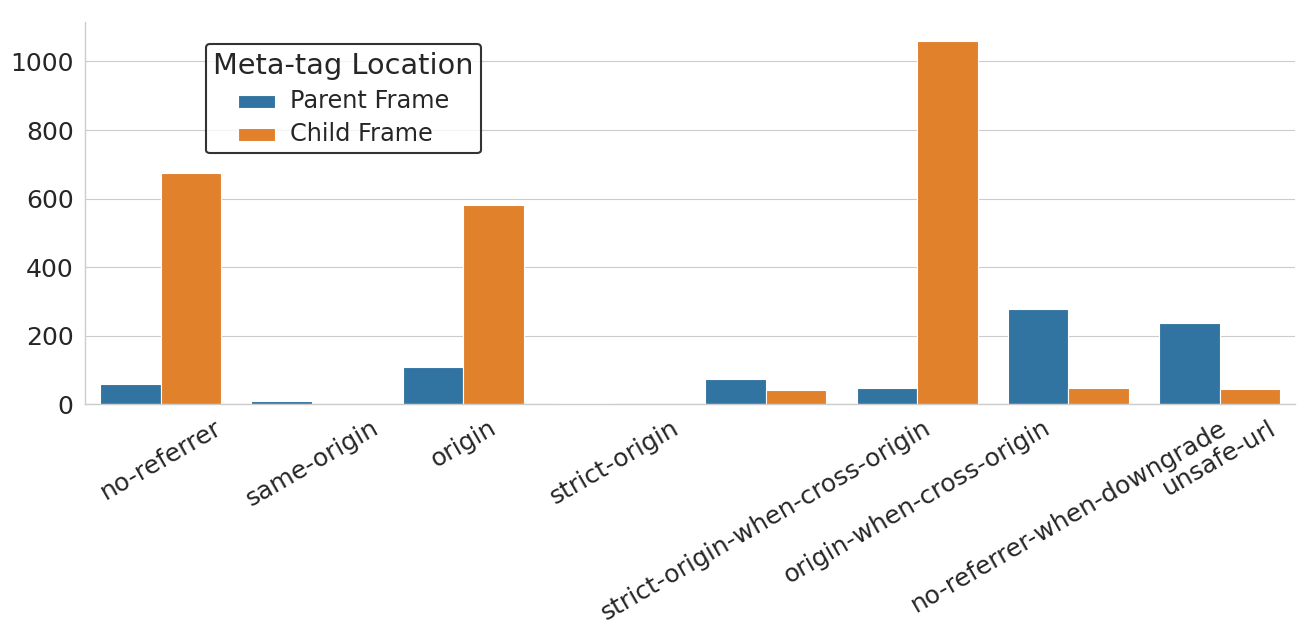

In [16]:
# For Figure 5
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)  # Increase font scale for better readability

# Create the plot
inFrame_graph = sns.catplot(
    data=inframe_meta_h,
    kind="bar",
    x="rp_value",
    y="value_counts",
    hue="inFrame",
    height=6,
    aspect=2
)

# Rotate x-axis tick labels and adjust tick label size
inFrame_graph.set_xticklabels(rotation=30)
plt.tick_params(axis="x", which="major", labelsize=14)

# Update legend labels (assuming the order is consistent)
new_labels = ["Parent Frame", "Child Frame"]
for text_obj, new_label in zip(inFrame_graph._legend.texts, new_labels):
    text_obj.set_text(new_label)

# Customize the legend
inFrame_graph._legend.set_title("Meta-tag Location")
inFrame_graph._legend.get_title().set_fontsize("x-large")
inFrame_graph._legend.set_bbox_to_anchor((0.15, 1))
inFrame_graph._legend.set_loc("upper left")
inFrame_graph._legend.set_frame_on(True)
inFrame_graph._legend.get_frame().set_edgecolor("black")
inFrame_graph._legend.get_frame().set_linewidth(1.5)
for text in inFrame_graph._legend.get_texts():
    text.set_fontsize("large")

# Remove axis labels if desired
inFrame_graph.set_axis_labels("", "")

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.tick_params(axis="both", which="major", labelsize=18)

# Save the figure with high resolution (300 dpi is usually good for print)
plt.savefig("../../output/chart/"+extract_type+"_inFrameMeta.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

# Response RP


In [17]:
# resp_file = '../../output/data_raw/2025-02-08_noAct_raw.parquet'
resp_file = '../../output/data_raw/2024-01-24_SF_raw.parquet'

resp = pd.read_parquet(resp_file)

In [18]:
resp = clean_dataset(resp, intersection)

In [19]:
resp.groupby('response_ref_policy').final_host.nunique()

response_ref_policy
                                                                                                       84
*                                                                                                       1
---NO REFERRER POLICY HEADERS---                                                                     9196
Origin-when-cross-origin                                                                                2
SAME-ORIGIN                                                                                             1
                                                                                                     ... 
strict-origin-when-cross-origin, strict-origin-when-cross-origin, strict-origin-when-cross-origin       1
strict-orign-when-cross-origin                                                                          1
unsafe-url                                                                                            987
unsafe-url\nunsafe-url    

In [20]:
resp['response_rp_fix'] = resp[resp.response_ref_policy.notna()].parallel_apply(transform_response, axis=1)

In [21]:
resp.groupby('response_rp_fix').final_host.nunique()

response_rp_fix
ignored                            9331
no-referrer                        1413
no-referrer-when-downgrade         2485
origin                             1336
origin-when-cross-origin           1168
same-origin                        1851
strict-origin                       361
strict-origin-when-cross-origin    7397
unsafe-url                          988
Name: final_host, dtype: int64

In [22]:
response_rp_3rd_party = create_resp_rp_stats_third_party_df(resp, RP_VALUES)


In [23]:
response_rp_3rd_party

,rp_value,third_party_resp,value_counts
0,no-referrer,False,1079
1,no-referrer,True,358
2,same-origin,False,1157
3,same-origin,True,761
4,origin,False,1138
5,origin,True,244
6,strict-origin,False,207
7,strict-origin,True,167
8,strict-origin-when-cross-origin,False,5192
9,strict-origin-when-cross-origin,True,2999


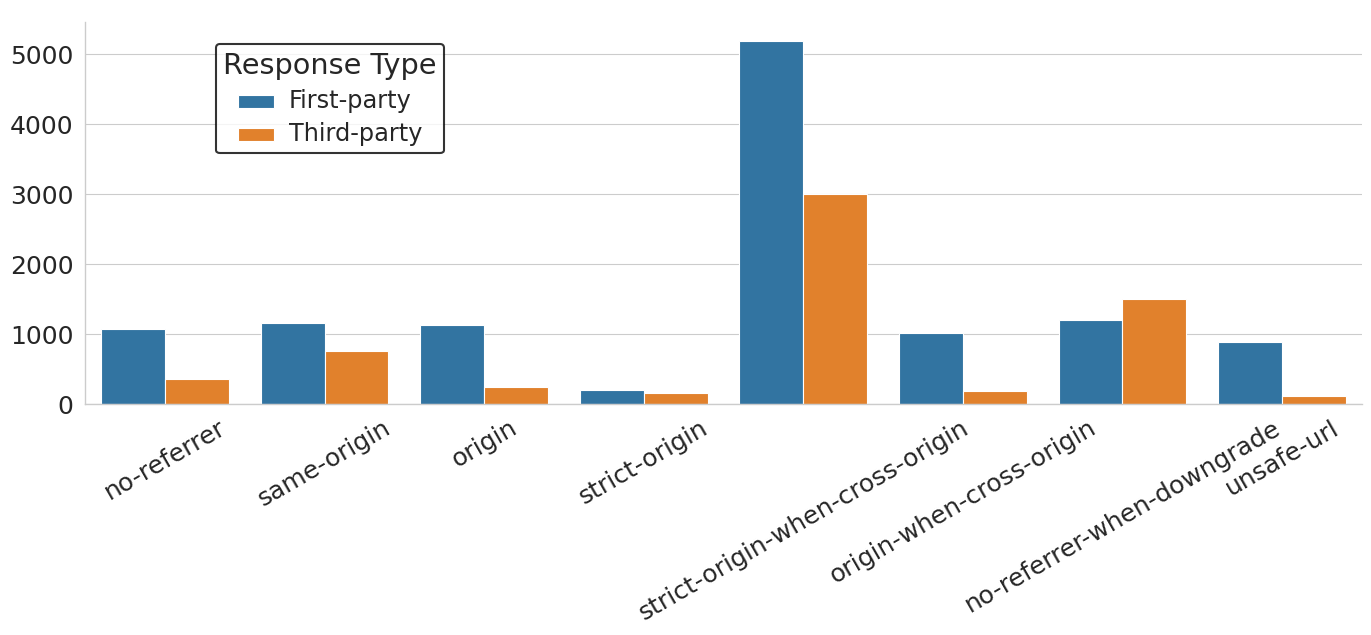

In [24]:
# Figure 4

# Create the plot
response_3rdparty_graph = sns.catplot(
    data=response_rp_3rd_party,
    kind="bar",
    x="rp_value",
    y="value_counts",
    hue="third_party_resp",
    height=6,
    aspect=2
)

# Rotate x-axis tick labels and adjust tick label size
response_3rdparty_graph.set_xticklabels(rotation=30)
plt.tick_params(axis="x", which="major", labelsize=14)

# Update legend labels (assuming the order is consistent)
new_labels = ['First-party', 'Third-party']
for text_obj, new_label in zip(response_3rdparty_graph._legend.texts, new_labels):
    text_obj.set_text(new_label)

# Customize the legend
response_3rdparty_graph._legend.set_title("Response Type")
response_3rdparty_graph._legend.get_title().set_fontsize("x-large")
response_3rdparty_graph._legend.set_bbox_to_anchor((0.15, 1))
response_3rdparty_graph._legend.set_loc("upper left")
response_3rdparty_graph._legend.set_frame_on(True)
response_3rdparty_graph._legend.get_frame().set_edgecolor("black")
response_3rdparty_graph._legend.get_frame().set_linewidth(1.5)
for text in response_3rdparty_graph._legend.get_texts():
    text.set_fontsize("large")

# Remove axis labels if desired
response_3rdparty_graph.set_axis_labels("", "")

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.tick_params(axis="both", which="major", labelsize=18)

# Save the figure with high resolution (300 dpi is usually good for print)
plt.savefig("../../output/chart/"+extract_type+"_ReponseThirdParty.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

# Total


In [25]:
doc_wide = doc_wide(meta, resp)
doc_wide.rp_effective.value_counts()

Websites that utilise meta-tags:  3040
Websites that utilise response: 12010
Websites that utilise doc-wide: 13264


rp_effective
strict-origin-when-cross-origin    7441
no-referrer-when-downgrade         2727
origin-when-cross-origin           2252
no-referrer                        2027
origin                             1939
same-origin                        1860
unsafe-url                         1228
strict-origin                       365
Name: count, dtype: int64